In [2]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import os
from osgeo import ogr
import gdal
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  

# hand made functions
from Rouss1 import gp2idomain, gp2cellids, get_heads, get_spdis, get_MNTbbox, import_riv
from Rouss1 import inter_lst,get_cellcenters, lin_interp,ibd_bcdata

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [3]:
model_dir = "working"
model_name = "first_2D"
exe_name= "../../exe/mf6"

In [4]:
R_path="../data/limiteModeleRoussillon_poly.shp" # path to the shp of the aquifer
MNT_path= "../data/MNT/MNT_50.tif"
Agly_path= "../data/Fleuves/Agly_ludo.shp" # path to Agly
Tet_path= "../data/Fleuves/Tet_ludo.shp"
Rea_path = "../data/Fleuves/Reart_ludo.shp"
Tech_path = "../data/Fleuves/Tech_ludo.shp"


In [5]:
#spatial parameters

# get x0,y0,y1 and x1 from the DEM
x0,y0,x1,y1 = get_MNTbbox(MNT_path)
x1 += 4000

Lx = x1-x0
Ly = y1-y0
nlay = 1
ncol = nrow = 200
delr = np.ones(ncol)*(Lx/ncol)
delc = np.ones(nrow)*(Ly/nrow)
botm = -50
top = 10. # if no mnt is provided
idomain = np.zeros((nrow*ncol))

In [6]:
# load top data
MNT = Raster.load(MNT_path)
grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0)

top = dem_data = MNT.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = MNT.bands[0],
                                method="nearest")

In [7]:
R = gp.read_file(R_path) # import shapefile with geopandas

#cells inside the aquifer become active and return the lst of the cellids
lst_domain = gp2idomain(R,grid,idomain,area=0) # all the cells of the model


In [8]:
### BC sea

# import the shapefile that correspond to the BC
BCsea_path = "../data/Sea_BC_L93.shp"
BC_sea = gp.read_file(BCsea_path)

# extract cellids from the BC at the sea and make these cells active
lst_chd = gp2cellids(grid,BC_sea,idomain,type="line")

# attribute a constant head at all the cells in the lst_chd
CHD = 0; chd_lst=[];
for x in lst_chd:
    chd_lst.append((x,CHD))

In [9]:
# BC etangs
BCetangs_path = "../../data/shp/Surface_hydro/SURFACE_HYDROGRAPHIQUE.shp"
Bcet = gp.read_file(BCetangs_path)
etangs = Bcet[(Bcet["TOPONYME"]=="étang de canet") | (Bcet["TOPONYME"]=="étang de leucate")]

# extract cellids from the BC 
etangs_chd = gp2cellids(grid,etangs.dissolve(by="NATURE"),idomain,areas=10)

# attribute a constant head
CHD = 0; et_chd_lst=[];
for x in etangs_chd:
    et_chd_lst.append((x,CHD))


In [10]:
# BC Agly
BC_Agly = gp.read_file(Agly_path) # read shp, linestring from ups to dws
df_agy = import_riv(grid,BC_Agly) # extract cellids intersected + lengths in each cells

#drop cellids which are already constant head
a = inter_lst(df_agy.cellids, lst_chd)
for i in range (len(a)):
    df_agy = df_agy.drop(df_agy[df_agy["cellids"] == a[i]].index)
    
# assign heads along the river
H_riv = lin_interp(df_agy.lengths,30,0)

# create the stress package
Agy_chd=[]; o =-1;
for x in df_agy.cellids:
    o = o + 1
    Agy_chd.append((x,H_riv[o]))

C:\Users\emmal\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [11]:
## BC Tet
gp_Tet = gp.read_file(Tet_path)
df_tet = import_riv(grid,gp_Tet)    

# assign heads along the river
df_tet["head"] = lin_interp(df_tet.lengths,140,0)

#drop cellids which are already constant heads
for cellid in df_tet.cellids:
    if cellid in lst_chd:
        df_tet = df_tet.drop(df_tet[df_tet["cellids"] == cellid].index)
    if cellid not in lst_domain:
        df_tet = df_tet.drop(df_tet[df_tet["cellids"]== cellid].index)

df_tet = df_tet.reset_index()
H_riv = df_tet["head"]
# create the stress package
Tet_chd=[]; o =-1;
for x in df_tet.cellids:
    o = o + 1
    Tet_chd.append((x,H_riv[o]))

In [12]:
## BC Reart
gp_riv = gp.read_file(Rea_path)
df_riv = import_riv(grid,gp_riv) # extract cellids from the river, in order with associated lengths   

# assign heads along the river
df_riv["head"] = lin_interp(df_riv.lengths,100,-10)

# drop some cells
for cellid in df_riv.cellids:
    if (cellid in lst_chd) | (cellid in etangs_chd):
        df_riv = df_riv.drop(df_riv[df_riv["cellids"] == cellid].index)
    if cellid not in lst_domain:
        df_riv = df_riv.drop(df_riv[df_riv["cellids"]== cellid].index)


df_riv= df_riv.reset_index()
H_riv = df_riv["head"]
# create the stress package
Rea_chd=[]; o =-1;
for x in df_riv.cellids:
    o = o + 1
    Rea_chd.append((x,H_riv[o]))

In [13]:
#BC Tech
gp_riv = gp.read_file(Tech_path)
df_riv = import_riv(grid,gp_riv) # extract cellids from the river, in order with associated lengths   

# assign heads along the river
df_riv["head"] = lin_interp(df_riv.lengths,125,0)

# drop some cells
for cellid in df_riv.cellids:
    if (cellid in lst_chd) | (cellid in etangs_chd):
        df_riv = df_riv.drop(df_riv[df_riv["cellids"] == cellid].index)
    if cellid not in lst_domain:
        df_riv = df_riv.drop(df_riv[df_riv["cellids"]== cellid].index)

df_riv = df_riv.reset_index()
H_riv = df_riv["head"]
# create the stress package
Tech_chd=[]; o =-1;
for x in df_riv.cellids:
    o = o + 1
    Tech_chd.append((x,H_riv[o]))

In [14]:
chd_lst

[((0, 5, 176), 0),
 ((0, 6, 176), 0),
 ((0, 6, 177), 0),
 ((0, 6, 178), 0),
 ((0, 6, 179), 0),
 ((0, 7, 179), 0),
 ((0, 7, 180), 0),
 ((0, 7, 181), 0),
 ((0, 8, 181), 0),
 ((0, 9, 181), 0),
 ((0, 9, 182), 0),
 ((0, 9, 183), 0),
 ((0, 10, 183), 0),
 ((0, 11, 182), 0),
 ((0, 11, 183), 0),
 ((0, 12, 182), 0),
 ((0, 13, 182), 0),
 ((0, 14, 182), 0),
 ((0, 15, 182), 0),
 ((0, 16, 181), 0),
 ((0, 16, 182), 0),
 ((0, 17, 181), 0),
 ((0, 18, 181), 0),
 ((0, 19, 181), 0),
 ((0, 20, 180), 0),
 ((0, 20, 181), 0),
 ((0, 21, 180), 0),
 ((0, 22, 180), 0),
 ((0, 23, 180), 0),
 ((0, 24, 180), 0),
 ((0, 25, 180), 0),
 ((0, 26, 180), 0),
 ((0, 27, 180), 0),
 ((0, 28, 179), 0),
 ((0, 28, 180), 0),
 ((0, 29, 179), 0),
 ((0, 30, 179), 0),
 ((0, 31, 179), 0),
 ((0, 32, 179), 0),
 ((0, 33, 178), 0),
 ((0, 33, 179), 0),
 ((0, 34, 178), 0),
 ((0, 35, 178), 0),
 ((0, 36, 178), 0),
 ((0, 37, 178), 0),
 ((0, 38, 178), 0),
 ((0, 39, 178), 0),
 ((0, 40, 177), 0),
 ((0, 40, 178), 0),
 ((0, 41, 177), 0),
 ((0, 42, 17

In [15]:
# basic modules
sim = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name=exe_name, 
                             sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='simple')

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf)

# nodeflowproperty
kh = 1e-4
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=kh, save_flows=True,save_specific_discharge=True)

# recharge
mm = 80
rch  = fp.mf6.ModflowGwfrcha(gwf, recharge = mm/1000/365/86400)

# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'ALL')])

# constant heads packages
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(chd_lst), 
                                               stress_period_data={0: chd_lst}, save_flows=True)

etangs = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='eta', filename="eta.chd", maxbound=len(et_chd_lst), 
                                               stress_period_data={0: et_chd_lst}, save_flows=True)

Riv1 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='agy', filename="agy.chd", maxbound=len(Agy_chd), 
                                               stress_period_data={0: Agy_chd}, save_flows=True)

Riv2 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Tet', filename="Tet.chd", maxbound=len(Tet_chd), 
                                               stress_period_data={0: Tet_chd}, save_flows=True)

Riv3 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Rea', filename="Rea.chd", maxbound=len(Rea_chd), 
                                               stress_period_data={0: Rea_chd}, save_flows=True)

Riv4 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Tech', filename="Tech.chd", maxbound=len(Tech_chd), 
                                               stress_period_data={0: Tech_chd}, save_flows=True)

Text(0.5, 1.0, 'Layer 1: Constant Head Cells')

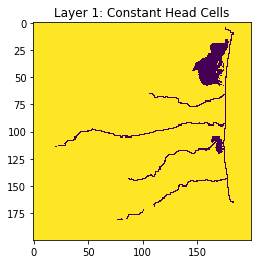

In [16]:
# vizualize the BC cells
iper = 0
ibd = np.ones((nlay, nrow, ncol), dtype=np.int)

ra = chd.stress_period_data.get_data(key=iper)
rb = Riv1.stress_period_data.get_data(key=iper)
rc = Riv2.stress_period_data.get_data(key=iper)
rd = Riv3.stress_period_data.get_data(key=iper)
re = etangs.stress_period_data.get_data(key=iper)
rf = Riv4.stress_period_data.get_data(key=iper)

for k, i, j in ra['cellid']:
    ibd[k, i, j] = -1
    
for k, i, j in rb['cellid']:
    ibd[k, i, j] = -1

for k, i, j in rc['cellid']:
    ibd[k, i, j] = -1

for k, i, j in rd['cellid']:
    ibd[k, i, j] = -1

for k, i, j in re['cellid']:
    ibd[k, i, j] = -1

for k, i, j in rf['cellid']:
    ibd[k, i, j] = -1

ilay = 0
plt.imshow(ibd[ilay, :, :], interpolation='none')
plt.title('Layer {}: Constant Head Cells'.format(ilay + 1))

In [17]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model first_2D...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package oc...
    writing package sea...
    writing package eta...
    writing package agy...
    writing package tet...
    writing package rea...
    writing package tech...


In [18]:
sim.run_simulation()

FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Soft

(True, [])

In [19]:
# retrieve heads and spdis 
head = get_heads(model_name,model_dir)
spdis = get_spdis(model_name,model_dir)

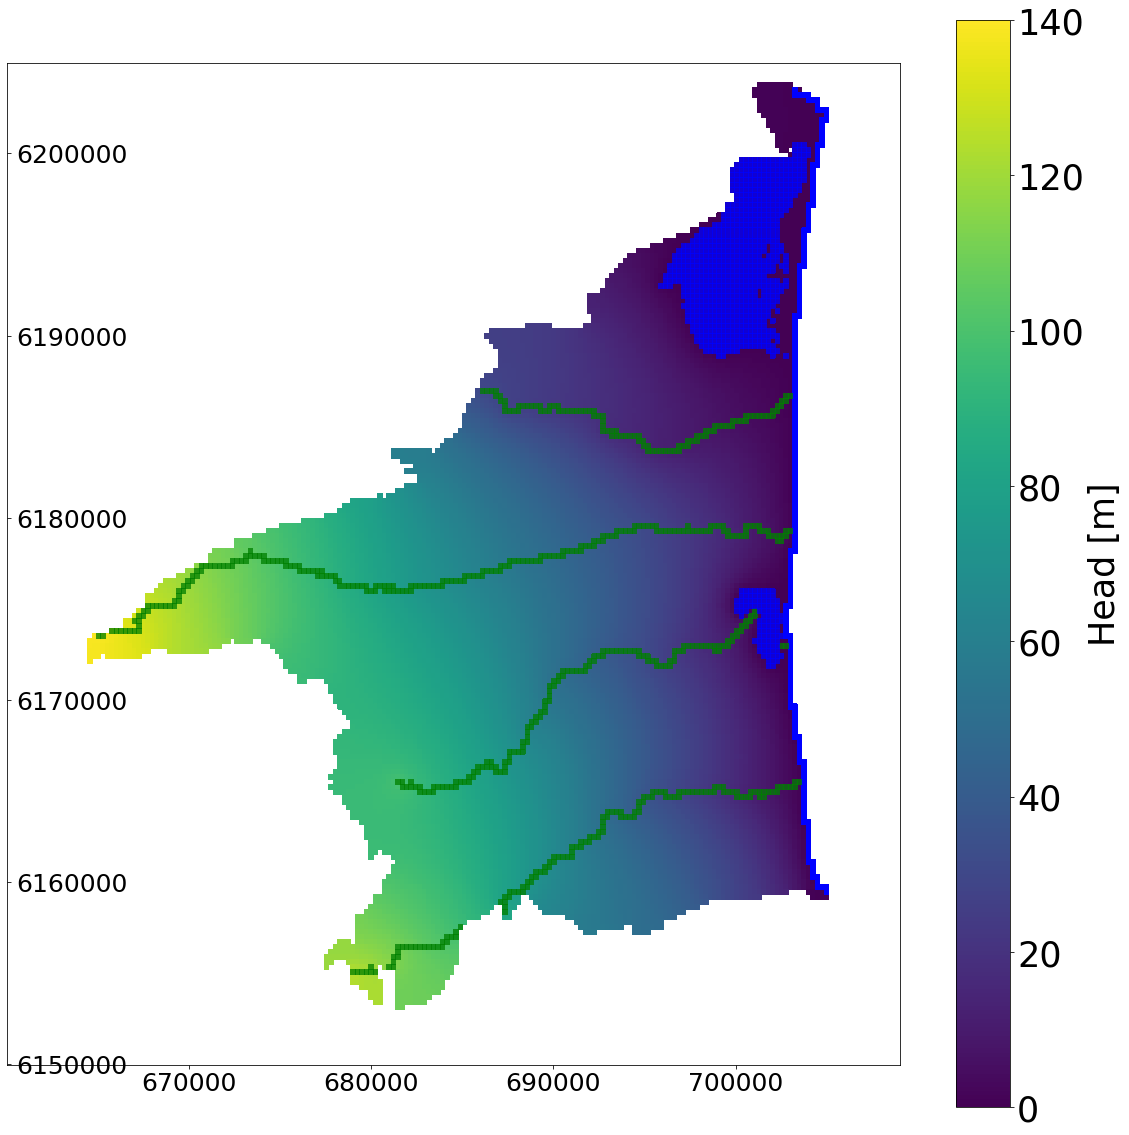

In [20]:
# make a plot
fig = plt.figure(figsize=(20,20))
ax  = plt.subplot(1, 1, 1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf)

#hmesh=ml.plot_ibound()
hmesh=ml.plot_array(head,masked_values=[1e30],cmap="viridis")
#ml.plot_specific_discharge(spdis[0],color="w",width=0.0030)
ml.plot_bc("sea",color="b")
ml.plot_bc("Tet",color="g",alpha=0.5)
ml.plot_bc("Rea",color="g",alpha=0.5)
ml.plot_bc("Agy",color="g",alpha=0.5)
ml.plot_bc("Tech",color="g",alpha=0.5)
ml.plot_bc("eta",color="b",alpha=0.5)
ax.tick_params(labelsize=25)
ax.tick_params(axis="y",direction="in", pad=-120)

g = plt.colorbar(hmesh)
hmesh.set_clim((0,140))
g.set_label("Head [m]",fontsize=35)
g.ax.tick_params(labelsize=35)

In [21]:
bdfile=[]
for file in os.listdir(model_dir):
    if file.endswith(".chd"):
        bdfile.append(os.path.splitext(file)[0])

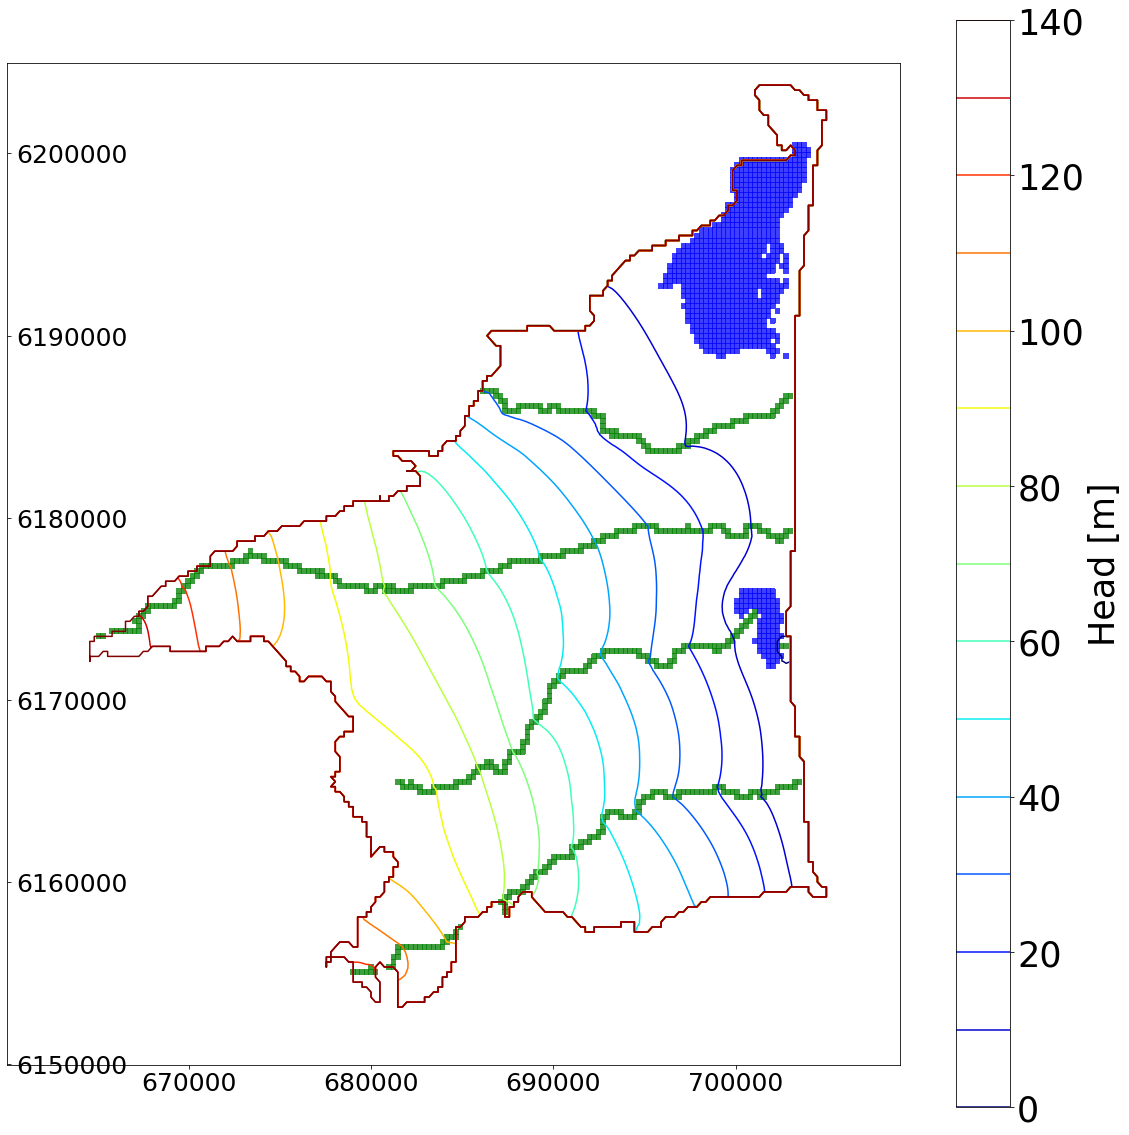

In [26]:
fig = plt.figure(figsize=(20,20))
ax  = plt.subplot(1, 1, 1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf)

hmesh=ml.contour_array(head,levels=np.linspace(0,140,15),cmap="jet")

ml.plot_bc("Tet",color="g",alpha=0.5)
ml.plot_bc("Rea",color="g",alpha=0.5)
ml.plot_bc("Agy",color="g",alpha=0.5)
ml.plot_bc("Tech",color="g",alpha=0.5)
ml.plot_bc("eta",color="b",alpha=0.5)

g=plt.colorbar(hmesh)
g.ax.tick_params(labelsize=35)
g.set_label("Head [m]",fontsize=35)
ax.tick_params(labelsize=25)
ax.tick_params(axis="y",direction="in", pad=-120)

In [23]:
# Total Budget
lstBudgetfile = "{}.lst".format(model_name)
fname = os.path.join(model_dir,lstBudgetfile)
Budgetobj = fp.utils.Mf6ListBudget(fname)

In [24]:
for i in Budgetobj.entries:
    if i != "PERCENT_DISCREPANCY":
        print("{} : {} m3/s".format(i,Budgetobj.get_budget(names=i)[0][0][-1]))

RCH_IN : 2.0745999813079834 m3/s
CHD_IN : 0.9247999787330627 m3/s
TOTAL_IN : 5.495200157165527 m3/s
RCH_OUT : 0.0 m3/s
CHD_OUT : 1.2019000053405762 m3/s
TOTAL_OUT : 5.495100021362305 m3/s
IN-OUT : 6.234500324353576e-05 m3/s
